In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy   as np
import xgboost as xgb

In [ ]:
# preparing categorical value
original_ds = pd.read_csv("chicago_listings.csv")

room_type_dict = sorted(original_ds["room_type"].unique().tolist()+["other"])
room_cat = pd.CategoricalDtype(categories=room_type_dict)

neighbourhood_dict = sorted(original_ds["neighbourhood"].unique().tolist()+["other"])
neigh_cat = pd.CategoricalDtype(categories=neighbourhood_dict)

over_priced = np.quantile(original_ds.price,.99)
over_priced

1010.0

In [ ]:
def feature_engineering(airbnb_pd):
  try:
    airbnb_pd = airbnb_pd[(airbnb_pd.id_flag==0)&
            (airbnb_pd.neighbourhood_flag==0)&(airbnb_pd.latitude_flag==0)&
          (airbnb_pd.longitude_flag==0)&(airbnb_pd.minimum_nights_flag==0)&
          (airbnb_pd.number_of_reviews_flag==0)&
          (airbnb_pd.room_type_flag==0)
          ]
  except:
    pass
  airbnb_pd = airbnb_pd[airbnb_pd.price<over_priced]
  airbnb_pd = airbnb_pd[airbnb_pd.price.isna()==False].copy().reset_index()

  airbnb_pd["latitude"] = airbnb_pd.latitude.fillna(0)
  airbnb_pd["longitude"] = airbnb_pd.longitude.fillna(0)
  airbnb_pd["number_of_reviews"] = airbnb_pd.number_of_reviews.fillna(0)
  airbnb_pd["minimum_nights"] = airbnb_pd.minimum_nights.fillna(0)
  airbnb_pd["reviews_per_month"] = airbnb_pd.reviews_per_month.fillna(0)

  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)
  airbnb_pd.loc[:,"reviews_per_month"] = airbnb_pd.reviews_per_month.astype(float)

  X_test = airbnb_pd[["latitude","longitude","minimum_nights","number_of_reviews"]]
  room_cat = pd.CategoricalDtype(categories=room_type_dict)
  airbnb_pd.room_type = airbnb_pd.room_type.astype(room_cat)
  X_test =pd.concat([X_test,pd.get_dummies(airbnb_pd.room_type,columns=room_type_dict,prefix="room_type",dummy_na=True,)],axis=1)
  neigh_cat = pd.CategoricalDtype(categories=neighbourhood_dict)
  airbnb_pd.neighbourhood = airbnb_pd.neighbourhood.astype(neigh_cat)
  X_test = pd.concat([X_test,pd.get_dummies(airbnb_pd.neighbourhood,columns=neighbourhood_dict,prefix="neighbourhood",dummy_na=True)],axis=1)

  y_test = airbnb_pd[["price"]]
  return X_test,y_test,airbnb_pd

In [ ]:
def transform_file(file_name):
  airbnb_pd = pd.read_csv(file_name)
  return feature_engineering(airbnb_pd)

In [ ]:
import os
from sklearn.metrics import mean_squared_log_error,mean_squared_error
from tqdm import tqdm

dir = "split_variation"

compiled_results = []

for dd in tqdm(os.listdir(dir)):
  #print(dd)
  d_split = f"{dir}/{dd}"
  # read original first
  X_train, y_train, _ = transform_file(f"{d_split}/train_original.csv")
  # read test file
  X_test, y_test, _ = transform_file(f"{d_split}/test.csv")
  # original performance

  regressor=xgb.XGBRegressor(learning_rate = 0.005,
                            n_estimators  = 500,
                            max_depth     = 7,
                            eval_metric='rmsle')

  regressor.fit(X_train, y_train)

  predictions = regressor.predict(X_test)
  RMSE = np.sqrt(mean_squared_error(y_test, predictions))
  predictions[predictions<0] = 0
  RMSLE = np.sqrt(mean_squared_log_error(y_test, predictions))
  #print("The score is %.5f" % RMSE )
  compiled_results.append((dd,"original",RMSE,RMSLE))
  for fl in tqdm(os.listdir(d_split)):
    if fl.find("cleaned") >= 0:
      #print(fl)
      X_train, y_train, _ = transform_file(f"{d_split}/{fl}")
      regressor=xgb.XGBRegressor(learning_rate = 0.005,
                            n_estimators  = 500,
                            max_depth     = 7,
                            eval_metric='rmsle')

      regressor.fit(X_train, y_train)

      predictions = regressor.predict(X_test)
      RMSE = np.sqrt( mean_squared_error(y_test, predictions))
      predictions[predictions<0] = 0
      RMSLE = np.sqrt(mean_squared_log_error(y_test, predictions))
      # predictions
      #print("The score is %.5f" % RMSE )
      compiled_results.append((dd,fl,RMSE,RMSLE))
      #break



In [ ]:
import os
from sklearn.metrics import mean_squared_log_error,mean_squared_error
from tqdm import tqdm

dir = "split_variation"

compiled_results = []

for dd in tqdm(os.listdir(dir)):
  #print(dd)
  d_split = f"{dir}/{dd}"
  # read original first
  X_train, y_train, ori_pd = transform_file(f"{d_split}/train_original.csv")
  # read test file
  X_test, y_test, test_pd = transform_file(f"{d_split}/test.csv")
  # original performance
  #compiled_results.append([dd,"ori",ori_pd.shape[0]])
  #print("The score is %.5f" % RMSE )
  for fl in tqdm(os.listdir(d_split)):
    if fl.find("cleaned") >= 0:
      print(fl)
      X_train, y_train, clean_pd = transform_file(f"{d_split}/{fl}")
      xx = ori_pd.merge(clean_pd,left_on="id",right_on="id",suffixes=("","_y")).loc[:,["latitude","longitude","minimum_nights","number_of_reviews","room_type","neighbourhood"]].reset_index(drop=True)
      yy =clean_pd.loc[:,["latitude","longitude","minimum_nights","number_of_reviews","room_type","neighbourhood"]].reset_index(drop=True)
      #accuracy = (xx==yy).sum().sum()/(ori_pd.shape[0]*6)
      accuracy = (xx!=yy).apply(lambda x:sum(x)>0,axis=1).sum()/(ori_pd.shape[0])
      completeness = clean_pd.shape[0]/ori_pd.shape[0]
      compiled_results.append([dd,fl,ori_pd.shape[0],clean_pd.shape[0],completeness,accuracy])
      #break
  #break


 19%|█▉        | 11/58 [00:00<00:00, 84.57it/s]

train_noise_40.csv_cleaned_baseline.csv
train_noise_30.csv_cleaned_baseline.csv
train_noise_15.csv_cleaned_baseline.csv
train_noise_25.csv_cleaned_baseline.csv
train_noise_10.csv_cleaned_baseline.csv
train_noise_35.csv_cleaned_baseline.csv
train_noise_5.csv_cleaned_baseline.csv
train_noise_20.csv_cleaned_baseline.csv
train_noise_15.csv_cleaned_baselineAverage.csv
train_noise_40.csv_cleaned_baselineAverage.csv



 34%|███▍      | 20/58 [00:03<00:08,  4.34it/s]

train_noise_30.csv_cleaned_baselineAverage.csv
train_noise_25.csv_cleaned_baselineAverage.csv
train_noise_5.csv_cleaned_baselineAverage.csv
train_noise_10.csv_cleaned_baselineAverage.csv



 41%|████▏     | 24/58 [00:06<00:10,  3.10it/s]

train_noise_35.csv_cleaned_baselineAverage.csv
train_noise_20.csv_cleaned_baselineAverage.csv
train_noise_40.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 47%|████▋     | 27/58 [00:07<00:10,  3.02it/s]

train_noise_30.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)


train_noise_15.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 50%|█████     | 29/58 [00:08<00:09,  3.01it/s]

train_noise_25.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 52%|█████▏    | 30/58 [00:08<00:09,  2.93it/s]

train_noise_10.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 53%|█████▎    | 31/58 [00:08<00:09,  2.92it/s]

train_noise_5.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 55%|█████▌    | 32/58 [00:09<00:09,  2.75it/s]

train_noise_35.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 57%|█████▋    | 33/58 [00:09<00:09,  2.59it/s]

train_noise_20.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 59%|█████▊    | 34/58 [00:10<00:09,  2.55it/s]

train_noise_40.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 88%|████████▊ | 51/58 [00:16<00:02,  2.45it/s]

train_noise_30.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 90%|████████▉ | 52/58 [00:17<00:02,  2.26it/s]

train_noise_15.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 91%|█████████▏| 53/58 [00:17<00:02,  2.02it/s]

train_noise_25.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 93%|█████████▎| 54/58 [00:18<00:01,  2.05it/s]

train_noise_10.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 95%|█████████▍| 55/58 [00:18<00:01,  2.22it/s]

train_noise_5.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 97%|█████████▋| 56/58 [00:18<00:00,  2.33it/s]

train_noise_35.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 98%|█████████▊| 57/58 [00:19<00:00,  2.40it/s]

train_noise_20.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

  0%|          | 0/58 [00:00<?, ?it/s]

train_noise_40.csv_cleaned_baseline.csv
train_noise_30.csv_cleaned_baseline.csv



 21%|██        | 12/58 [00:00<00:01, 34.24it/s]

train_noise_15.csv_cleaned_baseline.csv
train_noise_25.csv_cleaned_baseline.csv
train_noise_10.csv_cleaned_baseline.csv
train_noise_5.csv_cleaned_baseline.csv



 28%|██▊       | 16/58 [00:01<00:04,  9.07it/s]

train_noise_20.csv_cleaned_baseline.csv
train_noise_35.csv_cleaned_baseline.csv



 31%|███       | 18/58 [00:02<00:05,  7.10it/s]

train_noise_30.csv_cleaned_baselineAverage.csv
train_noise_40.csv_cleaned_baselineAverage.csv



 34%|███▍      | 20/58 [00:02<00:07,  5.23it/s]

train_noise_15.csv_cleaned_baselineAverage.csv



 36%|███▌      | 21/58 [00:03<00:07,  4.77it/s]

train_noise_25.csv_cleaned_baselineAverage.csv



 38%|███▊      | 22/58 [00:03<00:08,  4.26it/s]

train_noise_35.csv_cleaned_baselineAverage.csv



 40%|███▉      | 23/58 [00:03<00:08,  4.06it/s]

train_noise_10.csv_cleaned_baselineAverage.csv



 41%|████▏     | 24/58 [00:04<00:08,  3.78it/s]

train_noise_5.csv_cleaned_baselineAverage.csv



 43%|████▎     | 25/58 [00:04<00:09,  3.54it/s]

train_noise_20.csv_cleaned_baselineAverage.csv



 45%|████▍     | 26/58 [00:04<00:09,  3.51it/s]

train_noise_40.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 47%|████▋     | 27/58 [00:05<00:09,  3.38it/s]

train_noise_30.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 48%|████▊     | 28/58 [00:05<00:09,  3.25it/s]

train_noise_15.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 50%|█████     | 29/58 [00:05<00:09,  3.14it/s]

train_noise_10.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 52%|█████▏    | 30/58 [00:06<00:08,  3.20it/s]

train_noise_25.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 53%|█████▎    | 31/58 [00:06<00:08,  3.23it/s]

train_noise_5.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 55%|█████▌    | 32/58 [00:06<00:08,  3.24it/s]

train_noise_35.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 57%|█████▋    | 33/58 [00:06<00:07,  3.31it/s]

train_noise_20.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 59%|█████▊    | 34/58 [00:07<00:07,  3.16it/s]

train_noise_40.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 88%|████████▊ | 51/58 [00:12<00:02,  2.81it/s]

train_noise_30.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 90%|████████▉ | 52/58 [00:13<00:02,  2.79it/s]

train_noise_15.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 91%|█████████▏| 53/58 [00:13<00:01,  2.94it/s]

train_noise_25.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 93%|█████████▎| 54/58 [00:13<00:01,  2.98it/s]

train_noise_10.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 95%|█████████▍| 55/58 [00:14<00:00,  3.06it/s]

train_noise_5.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 97%|█████████▋| 56/58 [00:14<00:00,  3.11it/s]

train_noise_35.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 98%|█████████▊| 57/58 [00:14<00:00,  3.10it/s]

train_noise_20.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

  0%|          | 0/58 [00:00<?, ?it/s]

train_noise_40.csv_cleaned_baseline.csv
train_noise_15.csv_cleaned_baseline.csv



 21%|██        | 12/58 [00:00<00:01, 32.87it/s]

train_noise_30.csv_cleaned_baseline.csv
train_noise_5.csv_cleaned_baseline.csv
train_noise_10.csv_cleaned_baseline.csv
train_noise_25.csv_cleaned_baseline.csv



 28%|██▊       | 16/58 [00:01<00:05,  8.13it/s]

train_noise_20.csv_cleaned_baseline.csv
train_noise_35.csv_cleaned_baseline.csv



 31%|███       | 18/58 [00:02<00:06,  6.22it/s]

train_noise_40.csv_cleaned_baselineAverage.csv



 33%|███▎      | 19/58 [00:02<00:07,  5.57it/s]

train_noise_15.csv_cleaned_baselineAverage.csv



 34%|███▍      | 20/58 [00:02<00:07,  4.98it/s]

train_noise_30.csv_cleaned_baselineAverage.csv



 36%|███▌      | 21/58 [00:03<00:08,  4.50it/s]

train_noise_25.csv_cleaned_baselineAverage.csv



 38%|███▊      | 22/58 [00:03<00:08,  4.17it/s]

train_noise_10.csv_cleaned_baselineAverage.csv



 40%|███▉      | 23/58 [00:03<00:09,  3.81it/s]

train_noise_5.csv_cleaned_baselineAverage.csv



 41%|████▏     | 24/58 [00:04<00:09,  3.63it/s]

train_noise_35.csv_cleaned_baselineAverage.csv



 43%|████▎     | 25/58 [00:04<00:09,  3.45it/s]

train_noise_20.csv_cleaned_baselineAverage.csv



 45%|████▍     | 26/58 [00:04<00:09,  3.39it/s]

train_noise_40.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 47%|████▋     | 27/58 [00:05<00:09,  3.25it/s]

train_noise_30.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 48%|████▊     | 28/58 [00:05<00:09,  3.02it/s]

train_noise_15.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 50%|█████     | 29/58 [00:05<00:09,  2.92it/s]

train_noise_25.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 52%|█████▏    | 30/58 [00:06<00:08,  3.12it/s]

train_noise_10.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 53%|█████▎    | 31/58 [00:06<00:08,  3.23it/s]

train_noise_5.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 55%|█████▌    | 32/58 [00:06<00:08,  3.25it/s]

train_noise_20.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 57%|█████▋    | 33/58 [00:07<00:07,  3.34it/s]

train_noise_35.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 59%|█████▊    | 34/58 [00:07<00:06,  3.45it/s]

train_noise_40.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 88%|████████▊ | 51/58 [00:13<00:02,  2.92it/s]

train_noise_30.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 90%|████████▉ | 52/58 [00:13<00:02,  3.00it/s]

train_noise_15.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 91%|█████████▏| 53/58 [00:13<00:01,  2.94it/s]

train_noise_25.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 93%|█████████▎| 54/58 [00:14<00:01,  3.05it/s]

train_noise_10.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 95%|█████████▍| 55/58 [00:14<00:00,  3.06it/s]

train_noise_5.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 97%|█████████▋| 56/58 [00:14<00:00,  3.26it/s]

train_noise_35.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 98%|█████████▊| 57/58 [00:15<00:00,  3.33it/s]

train_noise_20.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

  0%|          | 0/58 [00:00<?, ?it/s]

train_noise_40.csv_cleaned_baseline.csv
train_noise_25.csv_cleaned_baseline.csv



 21%|██        | 12/58 [00:00<00:01, 34.86it/s]

train_noise_30.csv_cleaned_baseline.csv
train_noise_15.csv_cleaned_baseline.csv
train_noise_5.csv_cleaned_baseline.csv
train_noise_10.csv_cleaned_baseline.csv



 28%|██▊       | 16/58 [00:01<00:04,  9.11it/s]

train_noise_20.csv_cleaned_baseline.csv
train_noise_35.csv_cleaned_baseline.csv



 31%|███       | 18/58 [00:02<00:05,  6.90it/s]

train_noise_30.csv_cleaned_baselineAverage.csv
train_noise_15.csv_cleaned_baselineAverage.csv



 34%|███▍      | 20/58 [00:02<00:07,  5.12it/s]

train_noise_40.csv_cleaned_baselineAverage.csv



 36%|███▌      | 21/58 [00:03<00:07,  4.65it/s]

train_noise_25.csv_cleaned_baselineAverage.csv



 38%|███▊      | 22/58 [00:03<00:08,  4.33it/s]

train_noise_5.csv_cleaned_baselineAverage.csv



 40%|███▉      | 23/58 [00:03<00:08,  4.06it/s]

train_noise_10.csv_cleaned_baselineAverage.csv



 41%|████▏     | 24/58 [00:04<00:08,  3.88it/s]

train_noise_35.csv_cleaned_baselineAverage.csv



 43%|████▎     | 25/58 [00:04<00:08,  3.79it/s]

train_noise_20.csv_cleaned_baselineAverage.csv



 45%|████▍     | 26/58 [00:04<00:09,  3.48it/s]

train_noise_40.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 47%|████▋     | 27/58 [00:05<00:09,  3.39it/s]

train_noise_30.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 48%|████▊     | 28/58 [00:05<00:09,  3.29it/s]

train_noise_15.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 50%|█████     | 29/58 [00:05<00:09,  3.17it/s]

train_noise_25.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 52%|█████▏    | 30/58 [00:06<00:09,  2.96it/s]

train_noise_10.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 53%|█████▎    | 31/58 [00:06<00:09,  2.96it/s]

train_noise_5.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 55%|█████▌    | 32/58 [00:06<00:09,  2.84it/s]

train_noise_35.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 57%|█████▋    | 33/58 [00:07<00:08,  2.89it/s]

train_noise_20.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 59%|█████▊    | 34/58 [00:07<00:08,  2.90it/s]

train_noise_40.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 88%|████████▊ | 51/58 [00:13<00:02,  2.54it/s]

train_noise_30.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 90%|████████▉ | 52/58 [00:13<00:02,  2.74it/s]

train_noise_15.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 91%|█████████▏| 53/58 [00:14<00:02,  2.36it/s]

train_noise_25.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 93%|█████████▎| 54/58 [00:14<00:01,  2.57it/s]

train_noise_10.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 95%|█████████▍| 55/58 [00:14<00:01,  2.65it/s]

train_noise_5.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 97%|█████████▋| 56/58 [00:15<00:00,  2.69it/s]

train_noise_35.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 98%|█████████▊| 57/58 [00:15<00:00,  2.77it/s]

train_noise_20.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

  0%|          | 0/58 [00:00<?, ?it/s]

train_noise_40.csv_cleaned_baseline.csv
train_noise_25.csv_cleaned_baseline.csv



 21%|██        | 12/58 [00:00<00:01, 28.04it/s]

train_noise_15.csv_cleaned_baseline.csv
train_noise_30.csv_cleaned_baseline.csv
train_noise_5.csv_cleaned_baseline.csv



 26%|██▌       | 15/58 [00:01<00:04,  8.93it/s]

train_noise_10.csv_cleaned_baseline.csv
train_noise_20.csv_cleaned_baseline.csv



 29%|██▉       | 17/58 [00:01<00:05,  6.91it/s]

train_noise_35.csv_cleaned_baseline.csv



 31%|███       | 18/58 [00:02<00:06,  6.09it/s]

train_noise_40.csv_cleaned_baselineAverage.csv



 33%|███▎      | 19/58 [00:02<00:07,  5.09it/s]

train_noise_30.csv_cleaned_baselineAverage.csv



 34%|███▍      | 20/58 [00:03<00:08,  4.40it/s]

train_noise_15.csv_cleaned_baselineAverage.csv



 36%|███▌      | 21/58 [00:03<00:10,  3.61it/s]

train_noise_5.csv_cleaned_baselineAverage.csv



 38%|███▊      | 22/58 [00:03<00:11,  3.27it/s]

train_noise_10.csv_cleaned_baselineAverage.csv



 40%|███▉      | 23/58 [00:04<00:11,  3.12it/s]

train_noise_25.csv_cleaned_baselineAverage.csv



 41%|████▏     | 24/58 [00:04<00:12,  2.80it/s]

train_noise_20.csv_cleaned_baselineAverage.csv



 43%|████▎     | 25/58 [00:05<00:12,  2.71it/s]

train_noise_35.csv_cleaned_baselineAverage.csv



 45%|████▍     | 26/58 [00:05<00:11,  2.76it/s]

train_noise_30.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 47%|████▋     | 27/58 [00:05<00:11,  2.80it/s]

train_noise_40.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 48%|████▊     | 28/58 [00:06<00:09,  3.02it/s]

train_noise_25.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 50%|█████     | 29/58 [00:06<00:09,  3.13it/s]

train_noise_15.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 52%|█████▏    | 30/58 [00:06<00:08,  3.19it/s]

train_noise_5.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 53%|█████▎    | 31/58 [00:07<00:08,  3.10it/s]

train_noise_10.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 55%|█████▌    | 32/58 [00:07<00:08,  3.16it/s]

train_noise_35.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 57%|█████▋    | 33/58 [00:07<00:07,  3.14it/s]

train_noise_20.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 59%|█████▊    | 34/58 [00:07<00:07,  3.10it/s]

train_noise_40.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 88%|████████▊ | 51/58 [00:13<00:02,  3.18it/s]

train_noise_30.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 90%|████████▉ | 52/58 [00:13<00:01,  3.17it/s]

train_noise_15.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 91%|█████████▏| 53/58 [00:14<00:01,  3.22it/s]

train_noise_25.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 93%|█████████▎| 54/58 [00:14<00:01,  3.30it/s]

train_noise_10.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 95%|█████████▍| 55/58 [00:14<00:00,  3.15it/s]

train_noise_5.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 97%|█████████▋| 56/58 [00:15<00:00,  3.01it/s]

train_noise_35.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 98%|█████████▊| 57/58 [00:15<00:00,  3.04it/s]

train_noise_20.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

  0%|          | 0/58 [00:00<?, ?it/s]

train_noise_40.csv_cleaned_baseline.csv
train_noise_30.csv_cleaned_baseline.csv



 21%|██        | 12/58 [00:00<00:02, 18.91it/s]

train_noise_25.csv_cleaned_baseline.csv
train_noise_15.csv_cleaned_baseline.csv



 24%|██▍       | 14/58 [00:01<00:04,  9.29it/s]

train_noise_5.csv_cleaned_baseline.csv



 26%|██▌       | 15/58 [00:01<00:06,  6.97it/s]

train_noise_10.csv_cleaned_baseline.csv



 28%|██▊       | 16/58 [00:02<00:06,  6.03it/s]

train_noise_20.csv_cleaned_baseline.csv



 29%|██▉       | 17/58 [00:02<00:08,  4.82it/s]

train_noise_35.csv_cleaned_baseline.csv



 31%|███       | 18/58 [00:02<00:08,  4.59it/s]

train_noise_30.csv_cleaned_baselineAverage.csv



 33%|███▎      | 19/58 [00:03<00:09,  3.99it/s]

train_noise_40.csv_cleaned_baselineAverage.csv



 34%|███▍      | 20/58 [00:03<00:12,  2.95it/s]

train_noise_5.csv_cleaned_baselineAverage.csv



 36%|███▌      | 21/58 [00:04<00:12,  2.93it/s]

train_noise_15.csv_cleaned_baselineAverage.csv



 38%|███▊      | 22/58 [00:04<00:12,  2.97it/s]

train_noise_25.csv_cleaned_baselineAverage.csv



 40%|███▉      | 23/58 [00:04<00:11,  2.95it/s]

train_noise_10.csv_cleaned_baselineAverage.csv



 41%|████▏     | 24/58 [00:05<00:11,  2.97it/s]

train_noise_20.csv_cleaned_baselineAverage.csv



 43%|████▎     | 25/58 [00:05<00:10,  3.01it/s]

train_noise_35.csv_cleaned_baselineAverage.csv



 45%|████▍     | 26/58 [00:05<00:10,  2.99it/s]

train_noise_30.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 47%|████▋     | 27/58 [00:06<00:10,  2.96it/s]

train_noise_40.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 48%|████▊     | 28/58 [00:06<00:10,  2.87it/s]

train_noise_15.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 50%|█████     | 29/58 [00:06<00:10,  2.87it/s]

train_noise_10.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 52%|█████▏    | 30/58 [00:07<00:09,  2.97it/s]

train_noise_25.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 53%|█████▎    | 31/58 [00:07<00:09,  2.93it/s]

train_noise_5.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 55%|█████▌    | 32/58 [00:07<00:09,  2.83it/s]

train_noise_20.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 57%|█████▋    | 33/58 [00:08<00:08,  2.97it/s]

train_noise_35.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 59%|█████▊    | 34/58 [00:08<00:07,  3.03it/s]

train_noise_40.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 88%|████████▊ | 51/58 [00:14<00:02,  2.82it/s]

train_noise_30.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 90%|████████▉ | 52/58 [00:14<00:02,  2.84it/s]

train_noise_15.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 91%|█████████▏| 53/58 [00:15<00:01,  2.82it/s]

train_noise_25.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 93%|█████████▎| 54/58 [00:15<00:01,  2.86it/s]

train_noise_10.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 95%|█████████▍| 55/58 [00:15<00:01,  2.93it/s]

train_noise_5.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 97%|█████████▋| 56/58 [00:16<00:00,  3.03it/s]

train_noise_35.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 98%|█████████▊| 57/58 [00:16<00:00,  3.08it/s]

train_noise_20.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

  0%|          | 0/58 [00:00<?, ?it/s]

train_noise_30.csv_cleaned_baseline.csv
train_noise_15.csv_cleaned_baseline.csv



 21%|██        | 12/58 [00:00<00:01, 36.16it/s]

train_noise_40.csv_cleaned_baseline.csv
train_noise_25.csv_cleaned_baseline.csv
train_noise_10.csv_cleaned_baseline.csv
train_noise_5.csv_cleaned_baseline.csv



 28%|██▊       | 16/58 [00:01<00:04,  8.51it/s]

train_noise_35.csv_cleaned_baseline.csv
train_noise_20.csv_cleaned_baseline.csv



 31%|███       | 18/58 [00:02<00:05,  6.70it/s]

train_noise_40.csv_cleaned_baselineAverage.csv
train_noise_25.csv_cleaned_baselineAverage.csv



 34%|███▍      | 20/58 [00:02<00:07,  5.23it/s]

train_noise_15.csv_cleaned_baselineAverage.csv



 36%|███▌      | 21/58 [00:03<00:07,  4.80it/s]

train_noise_30.csv_cleaned_baselineAverage.csv



 38%|███▊      | 22/58 [00:03<00:08,  4.45it/s]

train_noise_5.csv_cleaned_baselineAverage.csv



 40%|███▉      | 23/58 [00:03<00:08,  4.19it/s]

train_noise_35.csv_cleaned_baselineAverage.csv



 41%|████▏     | 24/58 [00:04<00:08,  3.81it/s]

train_noise_10.csv_cleaned_baselineAverage.csv



 43%|████▎     | 25/58 [00:04<00:09,  3.52it/s]

train_noise_20.csv_cleaned_baselineAverage.csv



 45%|████▍     | 26/58 [00:04<00:09,  3.33it/s]

train_noise_40.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 47%|████▋     | 27/58 [00:05<00:09,  3.38it/s]

train_noise_15.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 48%|████▊     | 28/58 [00:05<00:09,  3.25it/s]

train_noise_30.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 50%|█████     | 29/58 [00:05<00:09,  3.14it/s]

train_noise_25.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 52%|█████▏    | 30/58 [00:06<00:08,  3.26it/s]

train_noise_5.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 53%|█████▎    | 31/58 [00:06<00:08,  3.22it/s]

train_noise_10.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 55%|█████▌    | 32/58 [00:06<00:08,  3.18it/s]

train_noise_35.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 57%|█████▋    | 33/58 [00:06<00:07,  3.27it/s]

train_noise_20.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 59%|█████▊    | 34/58 [00:07<00:07,  3.15it/s]

train_noise_40.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 88%|████████▊ | 51/58 [00:13<00:02,  3.05it/s]

train_noise_30.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 90%|████████▉ | 52/58 [00:13<00:01,  3.08it/s]

train_noise_15.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 91%|█████████▏| 53/58 [00:13<00:01,  3.19it/s]

train_noise_25.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 93%|█████████▎| 54/58 [00:14<00:01,  3.24it/s]

train_noise_10.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 95%|█████████▍| 55/58 [00:14<00:00,  3.37it/s]

train_noise_5.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 97%|█████████▋| 56/58 [00:14<00:00,  3.36it/s]

train_noise_35.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 98%|█████████▊| 57/58 [00:14<00:00,  3.31it/s]

train_noise_20.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

  0%|          | 0/58 [00:00<?, ?it/s]

train_noise_30.csv_cleaned_baseline.csv
train_noise_40.csv_cleaned_baseline.csv



 21%|██        | 12/58 [00:00<00:01, 29.40it/s]

train_noise_25.csv_cleaned_baseline.csv
train_noise_15.csv_cleaned_baseline.csv
train_noise_5.csv_cleaned_baseline.csv



 26%|██▌       | 15/58 [00:01<00:04,  8.75it/s]

train_noise_35.csv_cleaned_baseline.csv
train_noise_10.csv_cleaned_baseline.csv



 29%|██▉       | 17/58 [00:02<00:06,  6.32it/s]

train_noise_20.csv_cleaned_baseline.csv



 31%|███       | 18/58 [00:02<00:06,  5.72it/s]

train_noise_40.csv_cleaned_baselineAverage.csv



 33%|███▎      | 19/58 [00:02<00:07,  5.22it/s]

train_noise_25.csv_cleaned_baselineAverage.csv



 34%|███▍      | 20/58 [00:02<00:07,  4.77it/s]

train_noise_15.csv_cleaned_baselineAverage.csv



 36%|███▌      | 21/58 [00:03<00:08,  4.30it/s]

train_noise_30.csv_cleaned_baselineAverage.csv



 38%|███▊      | 22/58 [00:03<00:09,  3.90it/s]

train_noise_10.csv_cleaned_baselineAverage.csv



 40%|███▉      | 23/58 [00:04<00:10,  3.45it/s]

train_noise_5.csv_cleaned_baselineAverage.csv



 41%|████▏     | 24/58 [00:04<00:10,  3.21it/s]

train_noise_35.csv_cleaned_baselineAverage.csv



 43%|████▎     | 25/58 [00:04<00:11,  2.86it/s]

train_noise_20.csv_cleaned_baselineAverage.csv



 45%|████▍     | 26/58 [00:05<00:10,  3.01it/s]

train_noise_30.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 47%|████▋     | 27/58 [00:05<00:10,  3.07it/s]

train_noise_40.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 48%|████▊     | 28/58 [00:05<00:09,  3.13it/s]

train_noise_15.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 50%|█████     | 29/58 [00:06<00:10,  2.76it/s]

train_noise_25.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 52%|█████▏    | 30/58 [00:06<00:09,  2.94it/s]

train_noise_10.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 53%|█████▎    | 31/58 [00:06<00:08,  3.08it/s]

train_noise_35.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 55%|█████▌    | 32/58 [00:07<00:08,  3.03it/s]

train_noise_5.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 57%|█████▋    | 33/58 [00:07<00:08,  2.93it/s]

train_noise_20.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 59%|█████▊    | 34/58 [00:07<00:08,  2.89it/s]

train_noise_40.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 88%|████████▊ | 51/58 [00:13<00:02,  3.04it/s]

train_noise_30.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 90%|████████▉ | 52/58 [00:14<00:01,  3.08it/s]

train_noise_15.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 91%|█████████▏| 53/58 [00:14<00:01,  3.08it/s]

train_noise_25.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 93%|█████████▎| 54/58 [00:14<00:01,  3.03it/s]

train_noise_10.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 95%|█████████▍| 55/58 [00:15<00:01,  2.88it/s]

train_noise_5.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 97%|█████████▋| 56/58 [00:15<00:00,  2.95it/s]

train_noise_35.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 98%|█████████▊| 57/58 [00:15<00:00,  2.97it/s]

train_noise_20.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

  0%|          | 0/58 [00:00<?, ?it/s]

train_noise_30.csv_cleaned_baseline.csv
train_noise_15.csv_cleaned_baseline.csv



 21%|██        | 12/58 [00:00<00:01, 29.55it/s]

train_noise_40.csv_cleaned_baseline.csv
train_noise_25.csv_cleaned_baseline.csv
train_noise_10.csv_cleaned_baseline.csv



 26%|██▌       | 15/58 [00:01<00:04,  9.01it/s]

train_noise_5.csv_cleaned_baseline.csv
train_noise_35.csv_cleaned_baseline.csv



 29%|██▉       | 17/58 [00:01<00:06,  6.78it/s]

train_noise_20.csv_cleaned_baseline.csv



 31%|███       | 18/58 [00:02<00:06,  5.99it/s]

train_noise_15.csv_cleaned_baselineAverage.csv



 33%|███▎      | 19/58 [00:02<00:07,  5.05it/s]

train_noise_40.csv_cleaned_baselineAverage.csv



 34%|███▍      | 20/58 [00:02<00:08,  4.62it/s]

train_noise_30.csv_cleaned_baselineAverage.csv



 36%|███▌      | 21/58 [00:03<00:08,  4.13it/s]

train_noise_5.csv_cleaned_baselineAverage.csv



 38%|███▊      | 22/58 [00:03<00:09,  3.97it/s]

train_noise_25.csv_cleaned_baselineAverage.csv



 40%|███▉      | 23/58 [00:03<00:09,  3.61it/s]

train_noise_10.csv_cleaned_baselineAverage.csv



 41%|████▏     | 24/58 [00:04<00:10,  3.35it/s]

train_noise_35.csv_cleaned_baselineAverage.csv



 43%|████▎     | 25/58 [00:04<00:10,  3.05it/s]

train_noise_20.csv_cleaned_baselineAverage.csv



 45%|████▍     | 26/58 [00:05<00:10,  3.00it/s]

train_noise_40.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 47%|████▋     | 27/58 [00:05<00:10,  2.96it/s]

train_noise_30.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 48%|████▊     | 28/58 [00:05<00:10,  2.98it/s]

train_noise_15.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 50%|█████     | 29/58 [00:06<00:09,  2.91it/s]

train_noise_5.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 52%|█████▏    | 30/58 [00:06<00:10,  2.77it/s]

train_noise_10.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 53%|█████▎    | 31/58 [00:06<00:09,  2.79it/s]

train_noise_25.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 55%|█████▌    | 32/58 [00:07<00:09,  2.87it/s]

train_noise_35.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 57%|█████▋    | 33/58 [00:07<00:08,  3.05it/s]

train_noise_20.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 59%|█████▊    | 34/58 [00:07<00:07,  3.17it/s]

train_noise_40.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 88%|████████▊ | 51/58 [00:12<00:02,  3.34it/s]

train_noise_30.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 90%|████████▉ | 52/58 [00:13<00:01,  3.09it/s]

train_noise_15.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 91%|█████████▏| 53/58 [00:13<00:01,  2.99it/s]

train_noise_25.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 93%|█████████▎| 54/58 [00:14<00:01,  3.00it/s]

train_noise_10.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 95%|█████████▍| 55/58 [00:14<00:00,  3.12it/s]

train_noise_5.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 97%|█████████▋| 56/58 [00:14<00:00,  3.12it/s]

train_noise_35.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 98%|█████████▊| 57/58 [00:15<00:00,  2.96it/s]

train_noise_20.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

  0%|          | 0/58 [00:00<?, ?it/s]

train_noise_40.csv_cleaned_baseline.csv
train_noise_15.csv_cleaned_baseline.csv



 21%|██        | 12/58 [00:00<00:01, 39.83it/s]

train_noise_30.csv_cleaned_baseline.csv
train_noise_10.csv_cleaned_baseline.csv
train_noise_25.csv_cleaned_baseline.csv
train_noise_35.csv_cleaned_baseline.csv



 28%|██▊       | 16/58 [00:01<00:04,  8.74it/s]

train_noise_5.csv_cleaned_baseline.csv
train_noise_20.csv_cleaned_baseline.csv



 31%|███       | 18/58 [00:02<00:06,  6.41it/s]

train_noise_40.csv_cleaned_baselineAverage.csv
train_noise_30.csv_cleaned_baselineAverage.csv



 34%|███▍      | 20/58 [00:02<00:07,  5.11it/s]

train_noise_25.csv_cleaned_baselineAverage.csv



 36%|███▌      | 21/58 [00:03<00:08,  4.45it/s]

train_noise_15.csv_cleaned_baselineAverage.csv



 38%|███▊      | 22/58 [00:03<00:08,  4.13it/s]

train_noise_5.csv_cleaned_baselineAverage.csv



 40%|███▉      | 23/58 [00:03<00:09,  3.77it/s]

train_noise_10.csv_cleaned_baselineAverage.csv



 41%|████▏     | 24/58 [00:04<00:09,  3.56it/s]

train_noise_35.csv_cleaned_baselineAverage.csv



 43%|████▎     | 25/58 [00:04<00:09,  3.34it/s]

train_noise_20.csv_cleaned_baselineAverage.csv



 45%|████▍     | 26/58 [00:04<00:09,  3.41it/s]

train_noise_30.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 47%|████▋     | 27/58 [00:05<00:09,  3.35it/s]

train_noise_40.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 48%|████▊     | 28/58 [00:05<00:09,  3.24it/s]

train_noise_15.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 50%|█████     | 29/58 [00:05<00:09,  3.15it/s]

train_noise_25.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 52%|█████▏    | 30/58 [00:06<00:08,  3.16it/s]

train_noise_5.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 53%|█████▎    | 31/58 [00:06<00:08,  3.13it/s]

train_noise_10.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 55%|█████▌    | 32/58 [00:06<00:08,  3.22it/s]

train_noise_35.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 57%|█████▋    | 33/58 [00:07<00:07,  3.31it/s]

train_noise_20.csv_cleaned_curatorC1.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 59%|█████▊    | 34/58 [00:07<00:07,  3.29it/s]

train_noise_40.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC2.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_30.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_15.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_25.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_10.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_5.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_35.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_20.csv_cleaned_curatorC3.csv


<ipython-input-15-a8ec1c88f09f>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"latitude"] = airbnb_pd.latitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"longitude"] = airbnb_pd.longitude.astype(float)
<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, 

train_noise_40.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 88%|████████▊ | 51/58 [00:12<00:02,  3.27it/s]

train_noise_30.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 90%|████████▉ | 52/58 [00:13<00:01,  3.15it/s]

train_noise_15.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 91%|█████████▏| 53/58 [00:13<00:01,  3.20it/s]

train_noise_25.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 93%|█████████▎| 54/58 [00:13<00:01,  3.22it/s]

train_noise_10.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 95%|█████████▍| 55/58 [00:14<00:00,  3.16it/s]

train_noise_5.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 97%|█████████▋| 56/58 [00:14<00:00,  3.08it/s]

train_noise_35.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

 98%|█████████▊| 57/58 [00:14<00:00,  2.92it/s]

train_noise_20.csv_cleaned_curatorMerge.csv


<ipython-input-15-a8ec1c88f09f>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"number_of_reviews"] = airbnb_pd.number_of_reviews.astype(int)
<ipython-input-15-a8ec1c88f09f>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  airbnb_pd.loc[:,"minimum_nights"] = airbnb_pd.minimum_nights.astype(int)

100%|██████████| 10/10 [02:42<00:00, 16.23s/it]


In [ ]:
ori_pd

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,0,2384,Hyde Park - Walk to UChicago,2613,Rebecca,NaN,Hyde Park,41.787900,-87.587800,Private room,84,3,211,2022-11-18,2.18,1,365,19,R17000015609
1,1,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.902890,-87.681820,Entire home/apt,85,2,475,2022-12-05,2.90,1,325,45,R21000075737
2,2,1304049,Private room near UIC Medical Dist.,7089017,Sharon,NaN,Near West Side,41.871900,-87.684860,Private room,103,1,118,2022-10-15,1.04,1,363,8,R17000015307
3,3,3453656,Private large room with your own bathroom,17405364,Jennifer,NaN,Rogers Park,41.999930,-87.668440,Private room,122,14,39,2022-11-07,0.43,2,148,6,R21000073244
4,4,25879,2/1 One Block to Fullerton L Red Line Deck & ...,101521,Red,NaN,Lincoln Park,41.926930,-87.657530,Entire home/apt,94,32,50,2022-11-13,0.33,3,289,2,City registration pending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,3045,771711408944006841,McCormick Place 2b/2b w optional parking/sleeps 6,395498979,Milan,NaN,Near South Side,41.855460,-87.623740,Entire home/apt,204,2,0,NaN,0.00,56,353,0,2792126
3019,3046,771803500765098968,3BR Comfy & Bright Chicago Apartment,488113016,Alexis,NaN,North Center,41.951960,-87.677170,Entire home/apt,67,1,0,NaN,0.00,8,57,0,R22000089510
3020,3047,771833143252848397,Comfy Avondale Flat - Sleeps 4,150639375,Federico,NaN,Avondale,41.934130,-87.721730,Entire home/apt,79,2,0,NaN,0.00,4,347,0,R22000094210
3021,3048,771860062577897747,Comfy & Artistic 2BR Home in Francisco Ave,488113016,Alexis,NaN,West Ridge,41.996700,-87.701700,Entire home/apt,72,1,0,NaN,0.00,8,63,0,R21000062411


In [ ]:
clean_pd

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,...,license,id_flag,host_id_flag,neighbourhood_flag,latitude_flag,longitude_flag,minimum_nights_flag,number_of_reviews_flag,last_review_flag,room_type_flag
0,23,349265,Historic Chicago Home - Hyde Park,1517871,Jon,NaN,Hyde Park,41.80086,-87.58948,Entire home/apt,...,R18000030216,0,0,0,0,0,0,0,0,0
1,30,484898,Charming 1906 cottage Northside,2400107,Allison,NaN,NaN,41.97053,-87.67267,Entire home/apt,...,R17000013890,0,0,0,0,0,0,0,0,0
2,71,4503414,Private bedroom near the loop and McCormick Place,20059524,(Email hidden by Airbnb),NaN,Armour Square,41.85643,-87.63134,Private room,...,City registration pending,0,0,0,0,0,0,0,0,0
3,75,1027741,Chicago Women's Residence Midler Rm,5654677,Urban Art,NaN,South Lawndale,41.85308,-87.70718,Private room,...,R22000076746,0,0,0,0,0,0,0,0,0
4,92,5576191,Yellow room+ for 1-4 guests @ South Shore bung...,28501460,Delia,NaN,NaN,41.76264,-87.57232,Private room,...,R18000036975,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,3022,766680180203469794,Fully-equipped 2BR Unit in Wicker Park,480338513,Lane,NaN,NaN,41.90828,-87.66628,Entire home/apt,...,R21000062383,0,0,0,0,0,0,0,0,0
237,3067,44162298,NaN,169297663,William,NaN,West Town,41.90019,-87.66339,Entire home/apt,...,R22000089131,0,0,0,0,0,0,0,0,0
238,3743,715575750921525747,NaN,479447879,Roseland,NaN,NaN,41.69145,-87.61866,Private room,...,R22000087608,0,0,0,0,0,0,0,0,0
239,3793,24085799,NaN,60390549,Zhi,NaN,NaN,41.84786,-87.63127,Private room,...,R17000015797,0,0,0,0,0,0,0,0,0


In [ ]:
clean_pd

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,...,license,id_flag,host_id_flag,neighbourhood_flag,latitude_flag,longitude_flag,minimum_nights_flag,number_of_reviews_flag,last_review_flag,room_type_flag
0,23,349265,Historic Chicago Home - Hyde Park,1517871,Jon,NaN,Hyde Park,41.80086,-87.58948,Entire home/apt,...,R18000030216,0,0,0,0,0,0,0,0,0
1,30,484898,Charming 1906 cottage Northside,2400107,Allison,NaN,NaN,41.97053,-87.67267,Entire home/apt,...,R17000013890,0,0,0,0,0,0,0,0,0
2,71,4503414,Private bedroom near the loop and McCormick Place,20059524,(Email hidden by Airbnb),NaN,Armour Square,41.85643,-87.63134,Private room,...,City registration pending,0,0,0,0,0,0,0,0,0
3,75,1027741,Chicago Women's Residence Midler Rm,5654677,Urban Art,NaN,South Lawndale,41.85308,-87.70718,Private room,...,R22000076746,0,0,0,0,0,0,0,0,0
4,92,5576191,Yellow room+ for 1-4 guests @ South Shore bung...,28501460,Delia,NaN,NaN,41.76264,-87.57232,Private room,...,R18000036975,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,3022,766680180203469794,Fully-equipped 2BR Unit in Wicker Park,480338513,Lane,NaN,NaN,41.90828,-87.66628,Entire home/apt,...,R21000062383,0,0,0,0,0,0,0,0,0
237,3067,44162298,NaN,169297663,William,NaN,West Town,41.90019,-87.66339,Entire home/apt,...,R22000089131,0,0,0,0,0,0,0,0,0
238,3743,715575750921525747,NaN,479447879,Roseland,NaN,NaN,41.69145,-87.61866,Private room,...,R22000087608,0,0,0,0,0,0,0,0,0
239,3793,24085799,NaN,60390549,Zhi,NaN,NaN,41.84786,-87.63127,Private room,...,R17000015797,0,0,0,0,0,0,0,0,0


In [ ]:
xx = ori_pd.merge(clean_pd,left_on="id",right_on="id",suffixes=("","_y")).loc[:,["latitude","longitude","minimum_nights","number_of_reviews","room_type","neighbourhood"]].reset_index(drop=True)

In [ ]:
yy =clean_pd.loc[:,["latitude","longitude","minimum_nights","number_of_reviews","room_type","neighbourhood"]].reset_index(drop=True)

In [ ]:
xx

,latitude,longitude,minimum_nights,number_of_reviews,room_type,neighbourhood
0,41.800860,-87.589480,32,9,Entire home/apt,Hyde Park
1,41.970530,-87.672670,7,17,Entire home/apt,Uptown
2,41.856430,-87.631340,32,11,Private room,Armour Square
3,41.853080,-87.707180,32,5,Private room,South Lawndale
4,41.762640,-87.572320,32,35,Private room,South Shore
...,...,...,...,...,...,...
236,41.900338,-87.716728,1,2,Entire home/apt,Humboldt Park
237,41.936440,-87.644330,1,1,Entire home/apt,Lake View
238,41.847380,-87.645720,2,4,Private room,Bridgeport
239,41.907300,-87.666200,1,1,Entire home/apt,West Town


In [ ]:
(xx!=yy).apply(lambda x:sum(x)>0,axis=1).sum() #.sum() #/(2780*6)

211

In [ ]:
dc_metrics_pd = pd.DataFrame(compiled_results,columns=["var","clean_file","ori_rows","clean_rows","completeness","accuracy"])

In [ ]:
#pd.DataFrame(compiled_results,columns=["var","clean_file","ori_rows","clean_rows","completeness","accuracy"]).to_csv("completeness_accuracy_cleaned.csv")

In [ ]:
#compiled_results_pd = pd.DataFrame(compiled_results)

In [ ]:
import pandas as pd
compiled_results_pd = pd.read_csv("compiled_results_split_all.csv")
compiled_results_pd.columns = [0, 1, 2, 3, 'workflow', 'noise']
compiled_results_pd.columns

Index([0, 1, 2, 3, 'workflow', 'noise'], dtype='object')

In [ ]:
dc_metrics_pd = pd.read_csv("completeness_accuracy_cleaned.csv")

In [ ]:
compiled_results_pd.loc[compiled_results_pd[1]!='original',"workflow"] = compiled_results_pd[compiled_results_pd[1]!='original'][1].apply(lambda x:x.split("cleaned_")[1])

In [ ]:
compiled_results_pd.loc[compiled_results_pd[1]!='original',"noise"] = compiled_results_pd[compiled_results_pd[1]!='original'][1].apply(lambda x:x.split("train_noise_")[1].split(".")[0])

In [ ]:
compiled_results_pd=compiled_results_pd.merge(dc_metrics_pd,left_on=[0,1],right_on=["var","clean_file"],how="left")

In [ ]:
compiled_results_ori = compiled_results_pd[compiled_results_pd[1]=="original"]
compiled_results_noise = compiled_results_pd[compiled_results_pd[1]!="original"]

In [ ]:
compiled_results_noise.loc[:,"noise"] = compiled_results_noise.noise.astype(int)

<ipython-input-13-2f48a0d9fa91>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_results_noise.loc[:,"noise"] = compiled_results_noise.noise.astype(int)
<ipython-input-13-2f48a0d9fa91>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  compiled_results_noise.loc[:,"noise"] = compiled_results_noise.noise.astype(int)


array([[<Axes: title={'center': '3'}>]], dtype=object)

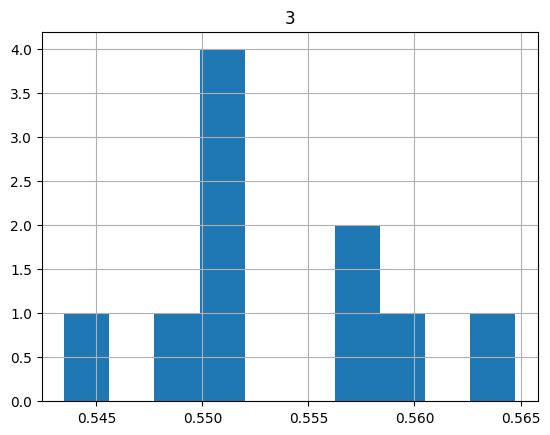

In [ ]:
compiled_results_ori[[3]].hist()

In [ ]:
compiled_results_noise = compiled_results_noise.merge(compiled_results_ori[[0,2,3]],left_on=0,right_on=0)

In [ ]:
compiled_results_pd

,0,1,2,3,workflow,noise,Unnamed: 0,var,clean_file,ori_rows,clean_rows,completeness,accuracy
0,split_0,original,119.363506,0.564748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,split_0,train_noise_40.csv_cleaned_baseline.csv,139.390294,0.705012,baseline.csv,40,0.0,split_0,train_noise_40.csv_cleaned_baseline.csv,3015.0,222.0,0.073632,0.068546
2,split_0,train_noise_30.csv_cleaned_baseline.csv,125.391370,0.604890,baseline.csv,30,1.0,split_0,train_noise_30.csv_cleaned_baseline.csv,3015.0,462.0,0.153234,0.032338
3,split_0,train_noise_15.csv_cleaned_baseline.csv,123.282688,0.591287,baseline.csv,15,2.0,split_0,train_noise_15.csv_cleaned_baseline.csv,3015.0,1091.0,0.361857,0.103704
4,split_0,train_noise_25.csv_cleaned_baseline.csv,124.393162,0.594218,baseline.csv,25,3.0,split_0,train_noise_25.csv_cleaned_baseline.csv,3015.0,610.0,0.202322,0.033444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,split_3,train_noise_25.csv_cleaned_curatorMerge.csv,116.741344,0.554575,curatorMerge.csv,25,475.0,split_3,train_noise_25.csv_cleaned_curatorMerge.csv,3023.0,2734.0,0.904400,0.904069
486,split_3,train_noise_10.csv_cleaned_curatorMerge.csv,116.395109,0.554858,curatorMerge.csv,10,476.0,split_3,train_noise_10.csv_cleaned_curatorMerge.csv,3023.0,2903.0,0.960304,0.960249
487,split_3,train_noise_5.csv_cleaned_curatorMerge.csv,116.328570,0.554773,curatorMerge.csv,5,477.0,split_3,train_noise_5.csv_cleaned_curatorMerge.csv,3023.0,2963.0,0.980152,0.980097
488,split_3,train_noise_35.csv_cleaned_curatorMerge.csv,117.551430,0.557452,curatorMerge.csv,35,478.0,split_3,train_noise_35.csv_cleaned_curatorMerge.csv,3023.0,2591.0,0.857096,0.856544


In [ ]:
compiled_results_noise

,0,1,2_x,3_x,workflow,noise,Unnamed: 0,var,clean_file,ori_rows,clean_rows,completeness,accuracy,2_y,3_y
0,split_0,train_noise_40.csv_cleaned_baseline.csv,139.390294,0.705012,baseline.csv,40,0.0,split_0,train_noise_40.csv_cleaned_baseline.csv,3015.0,222.0,0.073632,0.068546,119.363506,0.564748
1,split_0,train_noise_30.csv_cleaned_baseline.csv,125.391370,0.604890,baseline.csv,30,1.0,split_0,train_noise_30.csv_cleaned_baseline.csv,3015.0,462.0,0.153234,0.032338,119.363506,0.564748
2,split_0,train_noise_15.csv_cleaned_baseline.csv,123.282688,0.591287,baseline.csv,15,2.0,split_0,train_noise_15.csv_cleaned_baseline.csv,3015.0,1091.0,0.361857,0.103704,119.363506,0.564748
3,split_0,train_noise_25.csv_cleaned_baseline.csv,124.393162,0.594218,baseline.csv,25,3.0,split_0,train_noise_25.csv_cleaned_baseline.csv,3015.0,610.0,0.202322,0.033444,119.363506,0.564748
4,split_0,train_noise_10.csv_cleaned_baseline.csv,122.396085,0.568161,baseline.csv,10,4.0,split_0,train_noise_10.csv_cleaned_baseline.csv,3015.0,1419.0,0.470647,0.256440,119.363506,0.564748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,split_3,train_noise_25.csv_cleaned_curatorMerge.csv,116.741344,0.554575,curatorMerge.csv,25,475.0,split_3,train_noise_25.csv_cleaned_curatorMerge.csv,3023.0,2734.0,0.904400,0.904069,115.413276,0.551257
476,split_3,train_noise_10.csv_cleaned_curatorMerge.csv,116.395109,0.554858,curatorMerge.csv,10,476.0,split_3,train_noise_10.csv_cleaned_curatorMerge.csv,3023.0,2903.0,0.960304,0.960249,115.413276,0.551257
477,split_3,train_noise_5.csv_cleaned_curatorMerge.csv,116.328570,0.554773,curatorMerge.csv,5,477.0,split_3,train_noise_5.csv_cleaned_curatorMerge.csv,3023.0,2963.0,0.980152,0.980097,115.413276,0.551257
478,split_3,train_noise_35.csv_cleaned_curatorMerge.csv,117.551430,0.557452,curatorMerge.csv,35,478.0,split_3,train_noise_35.csv_cleaned_curatorMerge.csv,3023.0,2591.0,0.857096,0.856544,115.413276,0.551257


In [ ]:
compiled_results_noise["2_y"].unique().mean()

117.4163290906815

In [ ]:
compiled_results_noise["abs_delta_rmse"] = compiled_results_noise.apply(lambda x: abs(x["2_x"] - x["2_y"]) ,axis=1)
compiled_results_noise["abs_delta_rmsle"] = compiled_results_noise.apply(lambda x: abs(x["3_x"] - x["3_y"]) ,axis=1)
compiled_results_noise["delta_rmse"] = compiled_results_noise.apply(lambda x: x["2_x"] - x["2_y"] ,axis=1)
compiled_results_noise["delta_rmsle"] = compiled_results_noise.apply(lambda x: x["3_x"] - x["3_y"] ,axis=1)

In [ ]:
xx_compiled = compiled_results_noise.groupby(["workflow","noise"])[["2_x","3_x","delta_rmse","delta_rmsle"]].mean().merge(compiled_results_noise.groupby(["workflow","noise"])[["2_x","3_x","delta_rmse","delta_rmsle"]].std(),left_index=True,right_index=True,suffixes=("_mean","_std"))
xx_compiled

2_x_mean  3_x_mean  delta_rmse_mean  \
workflow            noise                                          
baseline.csv        5      121.260545  0.571571         3.844216   
                    10     122.306205  0.576674         4.889875   
                    15     122.926988  0.585961         5.510659   
                    20     124.508293  0.593210         7.091964   
                    25     128.796545  0.615333        11.380216   
                    30     129.487370  0.622321        12.071041   
                    35     132.521405  0.646918        15.105076   
                    40     138.543793  0.677504        21.127464   
baselineAverage.csv 5      118.410110  0.561106         0.993781   
                    10     119.109524  0.565298         1.693195   
                    15     119.552737  0.566848         2.136408   
                    20     120.041591  0.571610         2.625261   
                    25     120.485007  0.572372         3.068678   
                    30     120.600164  0.573835         3.183835   
                    35     120.856798  0.575072         3.440469   
                    40     120.829282  0.578939         3.412953   
curatorC1.csv       5      118.364898  0.558481         0.948569   
                    10     119.034239  0.561934         1.617910   
                    15     119.062308  0.560309         1.645979   
                    20     119.198770  0.563559         1.782440   
                    25     119.262726  0.562555         1.846397   
                    30     119.699651  0.566304         2.283322   
                    35     120.018481  0.566254         2.602152   
                    40     120.495245  0.569942         3.078916   
curatorC2.csv       5      118.437691  0.558607         1.021362   
                    10     119.256763  0.564094         1.840434   
                    15     119.786884  0.565383         2.370555   
                    20     119.988921  0.566857         2.572592   
                    25     120.351575  0.568930         2.935246   
                    30     120.723795  0.571471         3.307466   
                    35     120.863471  0.574255         3.447142   
                    40     122.106158  0.581906         4.689829   
curatorC3.csv       5      118.420018  0.558552         1.003689   
                    10     118.822032  0.560617         1.405703   
                    15     119.408920  0.564252         1.992591   
                    20     119.014227  0.561151         1.597898   
                    25     119.097004  0.562341         1.680675   
                    30     119.987072  0.566554         2.570743   
                    35     119.948209  0.566945         2.531880   
                    40     120.398796  0.570718         2.982467   
curatorMerge.csv    5      118.380875  0.558346         0.964546   
                    10     118.483660  0.558830         1.067331   
                    15     118.454796  0.558105         1.038467   
                    20     118.749524  0.560146         1.333195   
                    25     118.840388  0.559411         1.424059   
                    30     118.641973  0.559706         1.225644   
                    35     119.070082  0.561420         1.653753   
                    40     118.750376  0.560902         1.334047   

                           delta_rmsle_mean   2_x_std   3_x_std  \
workflow            noise                                         
baseline.csv        5              0.018073  2.081839  0.007627   
                    10             0.023177  1.808380  0.005060   
                    15             0.032463  2.463678  0.011437   
                    20             0.039712  2.804299  0.011537   
                    25             0.061836  4.900737  0.017840   
                    30             0.068824  5.721321  0.017217   
                    35             0.093421  6.839385  0.024580   
                    40   

In [ ]:
xx_compiled[["delta_rmse_mean","delta_rmse_std"]].reset_index().pivot(index="workflow",columns="noise",values=["delta_rmse_mean","delta_rmse_std"]) #transpose() (index='noise', columns="workflow", values='delta_rmse')

delta_rmse_mean                                           \
noise                            5         10        15        20         25   
workflow                                                                       
baseline.csv               3.844216  4.889875  5.510659  7.091964  11.380216   
baselineAverage.csv        0.993781  1.693195  2.136408  2.625261   3.068678   
curatorC1.csv              0.948569  1.617910  1.645979  1.782440   1.846397   
curatorC2.csv              1.021362  1.840434  2.370555  2.572592   2.935246   
curatorC3.csv              1.003689  1.405703  1.992591  1.597898   1.680675   
curatorMerge.csv           0.964546  1.067331  1.038467  1.333195   1.424059   

                                                     delta_rmse_std            \
noise                       30         35         40             5         10   
workflow                                                                        
baseline.csv         12.071041  15.105076  21.127464       1.527401  1.556932   
baselineAverage.csv   3.183835   3.440469   3.412953       0.582540  0.730839   
curatorC1.csv         2.283322   2.602152   3.078916       0.922665  0.908589   
curatorC2.csv         3.307466   3.447142   4.689829       0.849580  0.894583   
curatorC3.csv         2.570743   2.531880   2.982467       0.656706  0.701851   
curatorMerge.csv      1.225644   1.653753   1.334047       0.651421  0.874006   

                                                                       \
noise                      15        20        25        30        35   
workflow                                                                
baseline.csv         1.880763  1.907674  5.456137  5.864756  7.107096   
baselineAverage.csv  1.155012  1.480949  1.456404  1.320020  1.159024   
curatorC1.csv        0.733158  1.205917  1.259252  0.971231  1.014589   
curatorC2.csv        1.196581  1.516258  1.810627  1.481505  1.372855   
curatorC3.csv        0.995653  1.081575  1.358529  0.859995  1.497758   
curatorMerge.csv     0.678768  0.885658  0.653098  0.661357  0.755662   

                               
noise                      40  
workflow                       
baseline.csv         8.610738  
baselineAverage.csv  1.255674  
curatorC1.csv        2.099880  
curatorC2.csv        1.346554  
curatorC3.csv        1.202612  
curatorMerge.csv     0.879763

In [ ]:
compiled_results_noise

,0,1,2_x,3_x,workflow,noise,Unnamed: 0,var,clean_file,ori_rows,clean_rows,completeness,accuracy,2_y,3_y,abs_delta_rmse,abs_delta_rmsle,delta_rmse,delta_rmsle
0,split_0,train_noise_40.csv_cleaned_baseline.csv,139.390294,0.705012,baseline.csv,40,0.0,split_0,train_noise_40.csv_cleaned_baseline.csv,3015.0,222.0,0.073632,0.068546,119.363506,0.564748,20.026789,0.140264,20.026789,0.140264
1,split_0,train_noise_30.csv_cleaned_baseline.csv,125.391370,0.604890,baseline.csv,30,1.0,split_0,train_noise_30.csv_cleaned_baseline.csv,3015.0,462.0,0.153234,0.032338,119.363506,0.564748,6.027865,0.040142,6.027865,0.040142
2,split_0,train_noise_15.csv_cleaned_baseline.csv,123.282688,0.591287,baseline.csv,15,2.0,split_0,train_noise_15.csv_cleaned_baseline.csv,3015.0,1091.0,0.361857,0.103704,119.363506,0.564748,3.919182,0.026539,3.919182,0.026539
3,split_0,train_noise_25.csv_cleaned_baseline.csv,124.393162,0.594218,baseline.csv,25,3.0,split_0,train_noise_25.csv_cleaned_baseline.csv,3015.0,610.0,0.202322,0.033444,119.363506,0.564748,5.029656,0.029471,5.029656,0.029471
4,split_0,train_noise_10.csv_cleaned_baseline.csv,122.396085,0.568161,baseline.csv,10,4.0,split_0,train_noise_10.csv_cleaned_baseline.csv,3015.0,1419.0,0.470647,0.256440,119.363506,0.564748,3.032579,0.003413,3.032579,0.003413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,split_3,train_noise_25.csv_cleaned_curatorMerge.csv,116.741344,0.554575,curatorMerge.csv,25,475.0,split_3,train_noise_25.csv_cleaned_curatorMerge.csv,3023.0,2734.0,0.904400,0.904069,115.413276,0.551257,1.328068,0.003318,1.328068,0.003318
476,split_3,train_noise_10.csv_cleaned_curatorMerge.csv,116.395109,0.554858,curatorMerge.csv,10,476.0,split_3,train_noise_10.csv_cleaned_curatorMerge.csv,3023.0,2903.0,0.960304,0.960249,115.413276,0.551257,0.981833,0.003601,0.981833,0.003601
477,split_3,train_noise_5.csv_cleaned_curatorMerge.csv,116.328570,0.554773,curatorMerge.csv,5,477.0,split_3,train_noise_5.csv_cleaned_curatorMerge.csv,3023.0,2963.0,0.980152,0.980097,115.413276,0.551257,0.915294,0.003516,0.915294,0.003516
478,split_3,train_noise_35.csv_cleaned_curatorMerge.csv,117.551430,0.557452,curatorMerge.csv,35,478.0,split_3,train_noise_35.csv_cleaned_curatorMerge.csv,3023.0,2591.0,0.857096,0.856544,115.413276,0.551257,2.138154,0.006195,2.138154,0.006195


In [ ]:
import statsmodels.api as sm

In [ ]:
#X_train = sm.add_constant(compiled_results_noise[compiled_results_noise.workflow=="baseline.csv"][["noise"]].values, prepend=False)
X_train = compiled_results_noise[compiled_results_noise.workflow=="baseline.csv"][["noise"]].values
y_train = compiled_results_noise[compiled_results_noise.workflow=="baseline.csv"]["delta_rmse"].values
# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.839
Model:                            OLS   Adj. R-squared (uncentered):              0.837
Method:                 Least Squares   F-statistic:                              412.8
Date:                Sun, 04 Jun 2023   Prob (F-statistic):                    4.15e-33
Time:                        15:03:17   Log-Likelihood:                         -242.42
No. Observations:                  80   AIC:                                      486.8
Df Residuals:                      79   BIC:                                      489.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
#X_train = sm.add_constant(compiled_results_noise[compiled_results_noise.workflow=="baselineAverage.csv"][["noise"]].values, prepend=False)
X_train = compiled_results_noise[compiled_results_noise.workflow=="baselineAverage.csv"][["noise"]].values
y_train = compiled_results_noise[compiled_results_noise.workflow=="baselineAverage.csv"]["delta_rmse"].values
# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.822
Model:                            OLS   Adj. R-squared (uncentered):              0.820
Method:                 Least Squares   F-statistic:                              365.4
Date:                Sun, 04 Jun 2023   Prob (F-statistic):                    2.31e-31
Time:                        15:03:31   Log-Likelihood:                         -130.27
No. Observations:                  80   AIC:                                      262.5
Df Residuals:                      79   BIC:                                      264.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
#X_train = sm.add_constant(compiled_results_noise[compiled_results_noise.workflow=="curatorC1.csv"][["noise"]].values, prepend=False)
X_train = compiled_results_noise[compiled_results_noise.workflow=="curatorC1.csv"][["noise"]].values
y_train = compiled_results_noise[compiled_results_noise.workflow=="curatorC1.csv"]["delta_rmse"].values
# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.737
Model:                            OLS   Adj. R-squared (uncentered):              0.734
Method:                 Least Squares   F-statistic:                              221.5
Date:                Sun, 04 Jun 2023   Prob (F-statistic):                    1.25e-24
Time:                        15:03:35   Log-Likelihood:                         -128.94
No. Observations:                  80   AIC:                                      259.9
Df Residuals:                      79   BIC:                                      262.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
#X_train = sm.add_constant(compiled_results_noise[compiled_results_noise.workflow=="curatorC2.csv"][["noise"]].values, prepend=False)
X_train = compiled_results_noise[compiled_results_noise.workflow=="curatorC2.csv"][["noise"]].values
y_train = compiled_results_noise[compiled_results_noise.workflow=="curatorC2.csv"]["delta_rmse"].values
# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.825
Model:                            OLS   Adj. R-squared (uncentered):              0.823
Method:                 Least Squares   F-statistic:                              373.3
Date:                Sun, 04 Jun 2023   Prob (F-statistic):                    1.14e-31
Time:                        15:03:38   Log-Likelihood:                         -137.33
No. Observations:                  80   AIC:                                      276.7
Df Residuals:                      79   BIC:                                      279.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
#X_train = sm.add_constant(compiled_results_noise[compiled_results_noise.workflow=="curatorC3.csv"][["noise"]].values, prepend=False)
X_train = compiled_results_noise[compiled_results_noise.workflow=="curatorC3.csv"][["noise"]].values
y_train = compiled_results_noise[compiled_results_noise.workflow=="curatorC3.csv"]["delta_rmse"].values
# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.765
Model:                            OLS   Adj. R-squared (uncentered):              0.762
Method:                 Least Squares   F-statistic:                              257.0
Date:                Sun, 04 Jun 2023   Prob (F-statistic):                    1.50e-26
Time:                        15:03:38   Log-Likelihood:                         -122.58
No. Observations:                  80   AIC:                                      247.2
Df Residuals:                      79   BIC:                                      249.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
#X_train = sm.add_constant(compiled_results_noise[compiled_results_noise.workflow=="curatorMerge.csv"][["noise"]].values, prepend=False)
X_train = compiled_results_noise[compiled_results_noise.workflow=="curatorMerge.csv"][["noise"]].values
y_train = compiled_results_noise[compiled_results_noise.workflow=="curatorMerge.csv"]["delta_rmse"].values
# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.666
Model:                            OLS   Adj. R-squared (uncentered):              0.662
Method:                 Least Squares   F-statistic:                              157.6
Date:                Sun, 04 Jun 2023   Prob (F-statistic):                    1.67e-20
Time:                        15:03:42   Log-Likelihood:                         -100.14
No. Observations:                  80   AIC:                                      202.3
Df Residuals:                      79   BIC:                                      204.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
compiled_results_noise[["accuracy","completeness","delta_rmse"]].corr()

,accuracy,completeness,delta_rmse
accuracy,1.000000,0.794181,-0.446795
completeness,0.794181,1.000000,-0.671788
delta_rmse,-0.446795,-0.671788,1.000000


In [ ]:
compiled_results_noise["accuracy_normal"] = compiled_results_noise["accuracy"]/compiled_results_noise["completeness"]

In [ ]:
compiled_results_noise[["completeness","accuracy_normal"]].values

array([[0.07363184, 0.93093093],
       [0.15323383, 0.21103896],
       [0.36185738, 0.28658723],
       [0.20232172, 0.16530055],
       [0.47064677, 0.54486728],
       [0.10878939, 0.41514228],
       [0.62056385, 0.27944058],
       [0.26036484, 0.21740977],
       [1.        , 0.87860697],
       [1.        , 0.6854063 ],
       [1.        , 0.75975677],
       [1.        , 0.79955777],
       [1.        , 0.957822  ],
       [1.        , 0.91796573],
       [1.        , 0.72150359],
       [1.        , 0.83919292],
       [0.54859038, 0.99939541],
       [0.63615257, 0.99930483],
       [0.80729685, 0.99952068],
       [0.68855721, 0.99967887],
       [0.86865672, 0.99974545],
       [0.93266998, 0.99994073],
       [0.57810945, 0.99980876],
       [0.74792703, 0.99970436],
       [0.35190713, 0.55937795],
       [0.45704809, 0.23850992],
       [0.69021559, 0.29056543],
       [0.52935323, 0.18462824],
       [0.78606965, 0.27151899],
       [0.88723051, 0.26928349],
       [0.

In [ ]:
compiled_results_noise[["delta_rmse"]].values

array([[ 2.00267886e+01],
       [ 6.02786472e+00],
       [ 3.91918217e+00],
       [ 5.02965623e+00],
       [ 3.03257926e+00],
       [ 1.04088510e+01],
       [ 1.44185898e+00],
       [ 7.42362266e+00],
       [ 4.45804669e-01],
       [ 2.22025887e+00],
       [ 1.93964081e+00],
       [ 3.77752788e+00],
       [ 4.64779114e-01],
       [ 5.29295734e-01],
       [ 2.34557476e+00],
       [ 5.32583812e-02],
       [ 1.71025176e+00],
       [ 3.16088767e+00],
       [ 5.76168681e-01],
       [ 9.56234771e-01],
       [ 5.14926267e-01],
       [-6.59403360e-01],
       [ 2.12370867e+00],
       [-6.05109808e-01],
       [ 3.25312031e+00],
       [ 3.46162270e+00],
       [ 8.86368772e-01],
       [ 1.00158588e+00],
       [ 1.56954855e+00],
       [-2.82779849e-01],
       [ 2.64062822e+00],
       [ 3.74130908e-01],
       [ 1.86818416e+00],
       [ 1.33892360e+00],
       [ 9.91956692e-01],
       [ 8.53187370e-02],
       [ 1.00075046e+00],
       [ 6.63368869e-01],
       [ 1.8

In [ ]:
X_train = sm.add_constant(compiled_results_noise[compiled_results_noise.noise==40][["completeness"]].values, prepend=False)
y_train = compiled_results_noise[compiled_results_noise.noise==40]["delta_rmse"].values
# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     47.15
Date:                Wed, 31 May 2023   Prob (F-statistic):           4.91e-09
Time:                        19:33:46   Log-Likelihood:                -189.47
No. Observations:                  60   AIC:                             382.9
Df Residuals:                      58   BIC:                             387.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -16.8590      2.455     -6.867      0.0

In [ ]:
X_train = sm.add_constant(compiled_results_noise[compiled_results_noise.noise==40][["accuracy"]].values, prepend=False)
y_train = compiled_results_noise[compiled_results_noise.noise==40]["delta_rmse"].values
# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     3.214
Date:                Wed, 31 May 2023   Prob (F-statistic):             0.0782
Time:                        19:33:58   Log-Likelihood:                -205.70
No. Observations:                  60   AIC:                             415.4
Df Residuals:                      58   BIC:                             419.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -5.3341      2.975     -1.793      0.0

In [ ]:
X_train = sm.add_constant(compiled_results_noise[compiled_results_noise.noise==40][["accuracy_normal"]].values, prepend=False)
y_train = compiled_results_noise[compiled_results_noise.noise==40]["delta_rmse"].values
# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     3.214
Date:                Wed, 31 May 2023   Prob (F-statistic):             0.0782
Time:                        19:34:33   Log-Likelihood:                -205.70
No. Observations:                  60   AIC:                             415.4
Df Residuals:                      58   BIC:                             419.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -5.3341      2.975     -1.793      0.0

In [ ]:
#X_train = sm.add_constant(compiled_results_noise[compiled_results_noise.noise==40][["completeness","accuracy"]].values, prepend=False)
#y_train = compiled_results_noise[compiled_results_noise.noise==40]["delta_rmse"].values
X_train = sm.add_constant(compiled_results_noise[["completeness","accuracy"]].values, prepend=False)
y_train = compiled_results_noise["delta_rmse"].values

# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     212.9
Date:                Wed, 31 May 2023   Prob (F-statistic):           8.19e-67
Time:                        19:39:37   Log-Likelihood:                -1240.9
No. Observations:                 480   AIC:                             2488.
Df Residuals:                     477   BIC:                             2500.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -14.2873      0.912    -15.672      0.0

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from matplotlib import pyplot as plt

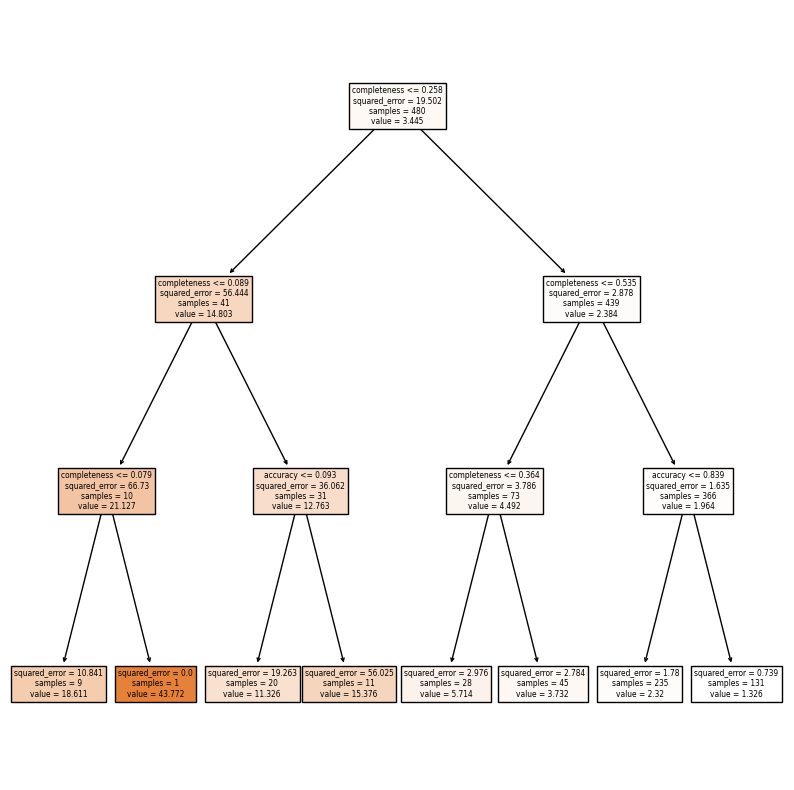

In [ ]:
regr = DecisionTreeRegressor(max_depth=3, random_state=77)
model = regr.fit(X_train, y_train)
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(regr, feature_names=["completeness","accuracy"], filled=True)

In [ ]:
compiled_results_noise[["completeness","accuracy"]].values.shape

(480, 2)

In [ ]:
compiled_results_noise["delta_rmse"].values.flatten().shape

(480,)

In [ ]:
ccpd = compiled_results_noise.groupby(["workflow","noise"]).mean().reset_index()
#ccpd[["workflow","noise","delta_rmse"]].plot(x="noise",y="delta_rmse")
ccpd.loc[:,"noise"] = ccpd.noise.astype(int)

NameError: ignored

In [ ]:
ccpd_pivot = ccpd.pivot(index='noise', columns="workflow", values='delta_rmse')
ccpd_pivot.columns = ["Baseline-Removal","Baseline-Average","WC1","WC2","WC3","WM"]
ccpd_pivot

,Baseline-Removal,Baseline-Average,WC1,WC2,WC3,WM
noise,,,,,,
5,3.844216,0.993781,0.948569,1.021362,1.003689,0.964546
10,4.889875,1.693195,1.617910,1.840434,1.405703,1.067331
15,5.510659,2.136408,1.645979,2.370555,1.992591,1.038467
20,7.091964,2.625261,1.782440,2.572592,1.597898,1.333195
25,11.380216,3.068678,1.846397,2.935246,1.680675,1.424059
30,12.071041,3.183835,2.283322,3.307466,2.570743,1.225644
35,15.105076,3.440469,2.602152,3.447142,2.531880,1.653753
40,21.127464,3.412953,3.078916,4.689829,2.982467,1.334047


In [ ]:
#compiled_results_pd.to_csv("compiled_results_split_all.csv",index=False)